In [35]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
import cv2
from matplotlib import pyplot as plt
from IPython import display

In [36]:
def load_norm(input_path):
    image = tf.io.read_file(input_path)
    image = tf.io.decode_jpeg(image)
    input_image = tf.cast(image, tf.float32)
    input_image = tf.image.resize(input_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = (input_image / 127.5) - 1
    return input_image

In [37]:
def load(input_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(input_path)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image


In [38]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, 256, 256)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [39]:
test_dataset = tf.data.Dataset.list_files('C:/Users/.../Desktop/face mask/face-mask/test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)


In [40]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [41]:
import tensorflow as tf

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,
                                           4,
                                           strides=2,
                                           padding="same",
                                           kernel_initializer=initializer,
                                           activation="tanh")  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



generator = Generator()
generator.load_weights('generator.h5')



In [42]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [43]:
# tar = load_norm("hamid.jpg")
# inp = load_norm("mask.jpg")
# image_tar = tf.expand_dims(tar, axis=0)
# image_inp = tf.expand_dims(inp, axis=0)




In [44]:
# generate_images(generator, image_inp, image_tar)

(1, 256, 256, 3)


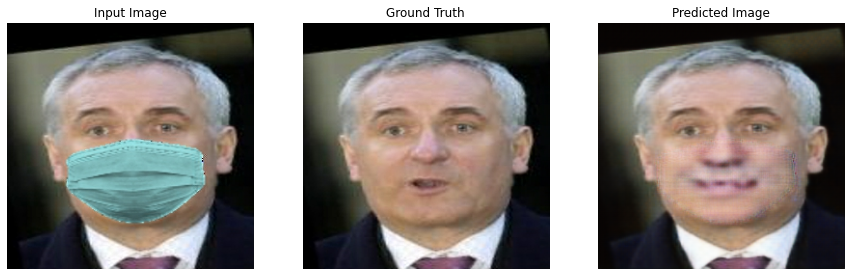

(1, 256, 256, 3)


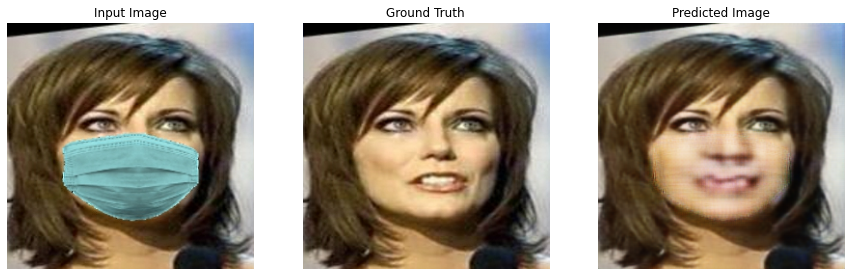

(1, 256, 256, 3)


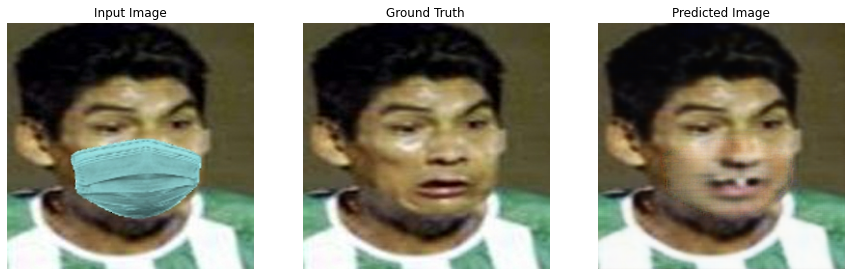

(1, 256, 256, 3)


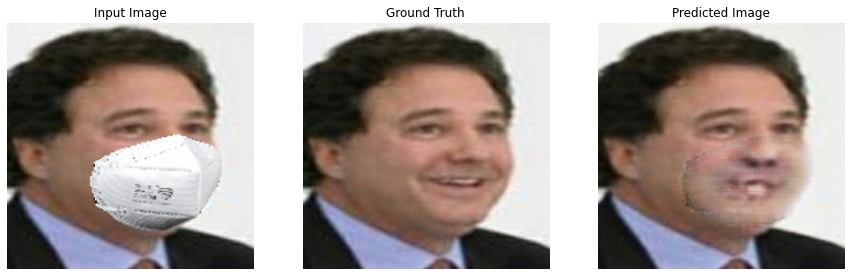

(1, 256, 256, 3)


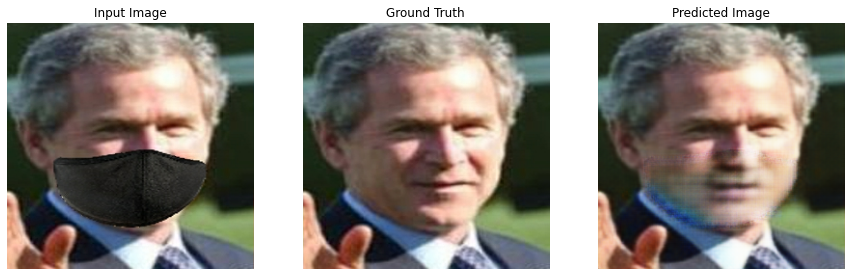

In [45]:
for inp, tar in test_dataset.take(5):
  print(inp.shape)
  generate_images(generator, inp, tar)

In [54]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np

# Define the function to generate and display images using the provided model
def generate_and_display():
    input_path = filedialog.askopenfilename(title="Select Input Image")
    if not input_path:
        return

    input_image = load_norm(input_path)
    input_image = tf.expand_dims(input_image, axis=0)
    
    generated_image = generator(input_image, training=True)

    input_image = (input_image[0] * 0.5 + 0.5)  # Convert to [0, 1] range for display
    generated_image = (generated_image[0] * 0.5 + 0.5)  # Convert to [0, 1] range for display

    # Display input and generated images
    input_photo = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(input_image * 255)))
    generated_photo = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(generated_image * 255)))

    input_label.config(image=input_photo)
    generated_label.config(image=generated_photo)

    input_label.image = input_photo
    generated_label.image = generated_photo

# Create the main Tkinter window
window = tk.Tk()
window.title("Image-to-Image Translation App")
window.geometry("1000x800")  # Set the window size

background_image = Image.open("background.jpg")  
background_photo = ImageTk.PhotoImage(background_image)

background_label = tk.Label(window, image=background_photo)
background_label.place(x=0, y=0, relwidth=1, relheight=1) 


# Create labels to display input and generated images
input_label = tk.Label(window, text="Input Image")
generated_label = tk.Label(window, text="Generated Image")


input_label.pack(pady=20)
generated_label.pack(pady=20)

# Create a button to trigger image generation
generate_button = tk.Button(window, text="Generate Image", command=generate_and_display)
generate_button.pack()

# Start the Tkinter main loop
window.mainloop()
